In [2]:
import numpy as np
import scipy.linalg as la
from matplotlib import pyplot as plt
%matplotlib inline
import utilities as ut

ModuleNotFoundError: No module named 'utilities'

In [192]:
def get_poles(position, velocity):
    # need to convert to kpc/s, otherwise numbers are too large for numpy to handle
    velocity = velocity*ut.constant.kpc_per_km
    if position.shape[0] == 3:
        j_vec_ = np.cross(position, velocity)/np.linalg.norm(np.cross(position, velocity))
    else:
        j_vec_ = np.array([np.cross(x,v)/np.linalg.norm(np.cross(x,v)) for x, v in zip(position, velocity)])
    return j_vec_

def get_angles_btwn_poles(lmc_pole, sat_poles):
    lmc_j_dot_j = np.array([np.dot(lmc_pole, sat_pole_i) for sat_pole_i in sat_poles])
    angles = np.degrees(np.arccos(lmc_j_dot_j, dtype=np.float64), dtype=np.float64)
    return angles

def orbital_pole_dispersion(j_vec, pole=False, both=False, lmc_pole=None):
    '''
    Calculate the angular dispersion [deg] of satellite orbital poles around
    their mean orbital pole or the LMC's pole.
    '''
    avg_j_vec = np.mean(j_vec, axis=0, dtype=np.float64)/np.linalg.norm(np.mean(j_vec, axis=0, dtype=np.float64), keepdims=True)
    avg_j_dot_j = np.array([np.dot(avg_j_vec, j_vec_i) for j_vec_i in j_vec])

    # replace values outside the domain of arccos [-1,1] with 1 or -1
    # assuming they are near (within 0.01) -1 or 1, meaning totally aligned with reference pole
    # and using nanmean to ignore anything out of these bounds
    avg_j_dot_j = np.where((avg_j_dot_j>1)&(avg_j_dot_j<1.01), 1, avg_j_dot_j)
    avg_j_dot_j = np.where((avg_j_dot_j<-1)&(avg_j_dot_j>-1.01), -1, avg_j_dot_j)
    pole_disp = np.sqrt(np.nanmean(np.arccos(avg_j_dot_j, dtype=np.float64)**2, dtype=np.float64))
    pole_disp = np.degrees(pole_disp, dtype=np.float64)

    return pole_disp

def orbital_pole_dispersion_old(position, velocity, pole=False, both=False, lmc_pole=None):
    '''
    Calculate the angular dispersion [deg] of satellite orbital poles around
    their mean orbital pole or the LMC's pole.
    '''
    j_vec = get_poles(position, velocity)
    avg_j_vec = np.mean(j_vec, axis=0, dtype=np.float64)/np.linalg.norm(np.mean(j_vec, axis=0, dtype=np.float64), keepdims=True)
    if lmc_pole is not None:
        avg_j_dot_j = np.array([np.dot(lmc_pole, j_vec_i) for j_vec_i in j_vec])
    else:
        avg_j_dot_j = np.array([np.dot(avg_j_vec, j_vec_i) for j_vec_i in j_vec])

    # these lines may or may not be necessary
    # replace values outside the domain of arccos [-1,1] with 1 or -1
    # assuming they are near (within 0.01) -1 or 1, meaning totally aligned with reference pole
    # and using nanmean to ignore anything out of these bounds
    avg_j_dot_j = np.where((avg_j_dot_j>1)&(avg_j_dot_j<1.01), 1, avg_j_dot_j)
    avg_j_dot_j = np.where((avg_j_dot_j<-1)&(avg_j_dot_j>-1.01), -1, avg_j_dot_j)
    pole_disp = np.sqrt(np.nanmean(np.arccos(avg_j_dot_j, dtype=np.float64)**2, dtype=np.float64))
    pole_disp = np.degrees(pole_disp, dtype=np.float64)

    if pole:
        return avg_j_vec
    elif both:
        return avg_j_vec, pole_disp
    else:
        return pole_disp

def orb_pole_aitoff(pole_arr):
    # convert poles to Galactocentric b,l (adapted from Ekta's code)
    b = np.arcsin(pole_arr[:,2])
    sinl = pole_arr[:,1]/np.cos(b)
    cosl = pole_arr[:,0]/np.cos(b)
    ll = np.arctan(sinl/cosl)

    l = np.zeros(len(ll))
    l = np.where((sinl >= 0.) & (cosl >= 0.), ll, l)
    l = np.where((sinl >= 0.) & (cosl <= 0.), ll + np.pi, l)
    l = np.where((sinl < 0.) & (cosl >= 0.), ll + 2.*np.pi, l)
    l = np.where((sinl < 0.) & (cosl < 0.), ll + np.pi, l)

    gl = np.degrees(l)
    gb = np.degrees(b)
    return gl, gb

def orbpole(r,v):
    ''' input: Cartesion position and velocity vector
        output: Galactic (l,b) in degrees'''
    x,y,z = r
    vx, vy, vz = v
    uu = np.cross([x,y,z], [vx,vy,vz])
    uumag = la.norm(uu)
    u = uu/uumag
    b = np.arcsin(u[2])
    sinl = u[1]/np.cos(b)
    cosl = u[0]/np.cos(b)
    ll = np.arctan(sinl/cosl)

    l = 0.
    if (sinl >= 0.) and (cosl >= 0.):
        l = ll 
    if (sinl >= 0.) and (cosl <= 0.):
        l = ll + np.pi 
    if (sinl < 0.) and (cosl >= 0.):
        l = ll + 2.*np.pi
    if (sinl < 0.) and (cosl < 0.):
        l = ll + np.pi

    gl = np.degrees(l)
    gb = np.degrees(b)
    return gl, gb

def orb_pole_aitoff_single(u):
    ''' input: Cartesion position and velocity vector
        output: Galactic (l,b) in degrees'''
    b = np.arcsin(u[2])
    sinl = u[1]/np.cos(b)
    cosl = u[0]/np.cos(b)
    ll = np.arctan(sinl/cosl)

    l = 0.
    if (sinl >= 0.) and (cosl >= 0.):
        l = ll 
    if (sinl >= 0.) and (cosl <= 0.):
        l = ll + np.pi 
    if (sinl < 0.) and (cosl >= 0.):
        l = ll + 2.*np.pi
    if (sinl < 0.) and (cosl < 0.):
        l = ll + np.pi

    gl = np.degrees(l)
    gb = np.degrees(b)
    return gl, gb

def color_cycle(cycle_length, cmap_name='plasma', low=0, high=1):
    cmap = plt.get_cmap(cmap_name)
    colors = cmap(np.linspace(low, high, cycle_length))

    return colors

In [165]:
DATA_DIR = '../data/'

m12b_halo = ut.io.file_hdf5(DATA_DIR+'m12b_host_halo_history.hdf5')
m12b_disc = ut.io.file_hdf5(DATA_DIR+'m12b_host_disc_history.hdf5')

# uncomment to choose a data file/set of subhalos/satellites
# subhalo info was generated from z=0-1
m12b_subhalos = ut.io.file_hdf5(DATA_DIR+'m12b_subhalo_history_nstar6_50-500kpc.hdf5')
#m12b_subhalos = ut.io.file_hdf5(DATA_DIR+'m12b_subhalo_history_mpeak1e8_50-500kpc.hdf5')


# in utilities.io.file_hdf5():
  reading file:  Users/jsamuel/Desktop/Latte/LMC_plane_effects/m12b_shared/data/m12b_host_halo_history.hdf5
    host.index | int32, shape = (601,)
    host.mass | float32, shape = (601,)
    host.position | float32, shape = (601, 3)
    host.radius | float32, shape = (601,)
    host.scale.radius | float32, shape = (601,)
    host.velocity | float32, shape = (601, 3)
    redshift | float64, shape = (601,)
    snapshot | int32, shape = (601,)
    time | float64, shape = (601,)

# in utilities.io.file_hdf5():
  reading file:  Users/jsamuel/Desktop/Latte/LMC_plane_effects/m12b_shared/data/m12b_host_disc_history.hdf5
    position | float32, shape = (601, 1, 3)
    redshift | float64, shape = (601,)
    rotation | float32, shape = (601, 1, 3, 3)
    snapshot | int32, shape = (601,)
    time | float64, shape = (601,)
    velocity | float32, shape = (601, 1, 3)

# in utilities.io.file_hdf5():
  reading file:  Users/jsamuel/Desktop/Latte/LMC_plane_effects/m12b_sh

### Specify info at LMC analog infall and pericenter

In [215]:
# snapshot, time, and tree index (unique idenitfier over subhalos and time) at infall
snap_at_lmc_infall = 353
t_infall = m12b_subhalos['time'][m12b_subhalos['snapshot'] == snap_at_lmc_infall]
m12b_lmc_tind_infall = 707093

# identify the LMC analog by index in m12b_subhalos for calculations below
lmc_subhalo_index = np.where(m12b_subhalos['tree.index'][snap_at_lmc_infall,:] == m12b_lmc_tind_infall)[0][0]

# snapshot, time, and tree index (unique idenitfier over subhalos and time) at first peri
snap_at_lmc_peri = 385
t_peri = m12b_subhalos['time'][m12b_subhalos['snapshot'] == snap_at_lmc_peri]
m12b_lmc_tind_peri = int(m12b_subhalos['tree.index'][snap_at_lmc_peri,lmc_subhalo_index])#508097

# snapshot, time, and tree index (unique idenitfier over subhalos and time) at second peri
snap_at_lmc_second_peri = 448
t_peri = m12b_subhalos['time'][m12b_subhalos['snapshot'] == snap_at_lmc_second_peri]
m12b_lmc_tind_second_peri = int(m12b_subhalos['tree.index'][snap_at_lmc_second_peri,lmc_subhalo_index])

# choose snapshots of interest for calculations/plotting
# subhalo info starts at z=1 (around snap 277)
# LMC analog merges into MW disk around 11 Gyr so stop then (around snap 470) 
near_infall_snapshots = np.arange(277,470,1)
near_infall_times = m12b_subhalos['time'][np.isin(m12b_subhalos['snapshot'], near_infall_snapshots)]

# set bins for getting alignment w/ LMC pole
angle_bins = np.arange(0,181,30)

### Add a flag ('LMC.sat') to m12b_subhalos for LMC satellites at each snap, and create mask for if something was ever an LMC sat

In [214]:
# track of LMC analog, can use for other properties
m12b_lmc_track = m12b_subhalos['tree.index'][:,lmc_subhalo_index]

ind_where_lmc_is_host = np.isin(m12b_subhalos['central.index'], m12b_lmc_track)
m12b_subhalos['LMC.sat'] = np.zeros(m12b_subhalos['central.index'].shape, dtype=bool)
m12b_subhalos['LMC.sat'][ind_where_lmc_is_host] = True

# mask for whether something was ever an LMC satellite
ever_LMC_sat = np.sum(m12b_subhalos['LMC.sat'], axis=0) > 0

### Get MW host info

In [158]:
# host disc position and velocity
disc_pos = m12b_disc['position']
disc_vel = m12b_disc['velocity']

# host position and velocity
halo_pos = m12b_halo['host.position']
halo_vel = m12b_halo['host.velocity']

# mask out the MW host track b/c the LMC has merged with the MW
m12b_host_index_z0 = 0
host_track = m12b_halo['host.index']# last element is a dummy variable
#host_mask = ~(tree['host.index'] == np.arange(len(tree['host.index'])))

### Get orbital poles of subhalos wrt disc center

In [160]:
pole_snap_arr = np.full_like(m12b_subhalos['position'], np.nan)

for snap in near_infall_snapshots:
    # first mask out nan-entry subhalos at each snapshot
    # these are subhalos that were within 50-500 kpc of the host halo at some point during z=0-1
    # but do not exist in the tree at this snapshot
    subhalo_positions = np.compress(~np.isnan(m12b_subhalos['position'][snap,:,0]), m12b_subhalos['position'][snap,:,:], axis=0)
    subhalo_velocities = np.compress(~np.isnan(m12b_subhalos['velocity'][snap,:,0]), m12b_subhalos['velocity'][snap,:,:], axis=0)
    assert subhalo_positions.shape == subhalo_velocities.shape

    # convert to a disc-centered coordinate system
    subhalo_disc_position = ut.coordinate.get_distances(subhalo_positions, disc_pos[snap,0,:])
    subhalo_disc_velocity = ut.coordinate.get_distances(subhalo_velocities, disc_vel[snap,0,:])

    poles = get_poles(subhalo_disc_position, subhalo_disc_velocity)

    # broadcast only to where there were extant subhalos in the tree
    tracked_sub_indices = np.asarray(~np.isnan(m12b_subhalos['position'][snap,:,0])).nonzero()
    pole_snap_arr[snap,tracked_sub_indices,:] = poles

### Get angles between subhalo poles and lmc pole at lmc infall and plot histogram
### Plot number of subhalos in angle bins and their average orbital pole over time

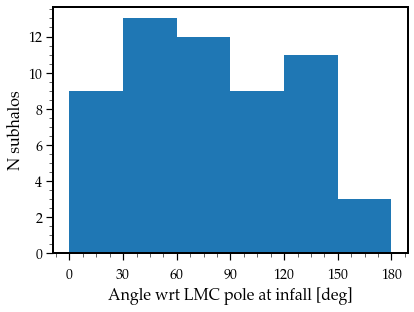

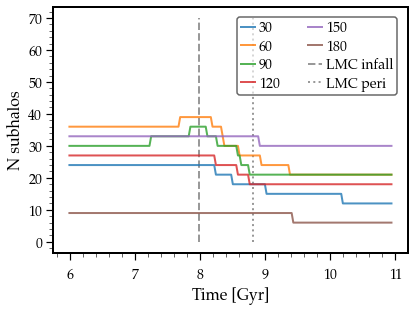

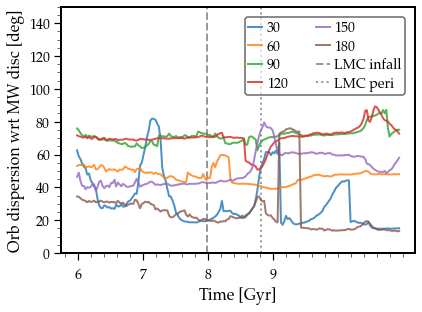

In [180]:
lmc_orb_poles = pole_snap_arr[:,lmc_subhalo_index,:]
lmc_pole_at_infall = lmc_orb_poles[snap_at_lmc_infall]
lmc_pole_at_peri = lmc_orb_poles[snap_at_lmc_peri]
pole_angle_wrt_lmc = get_angles_btwn_poles(lmc_pole_at_infall, pole_snap_arr[snap_at_lmc_infall,:,:])

plt.hist(np.abs(pole_angle_wrt_lmc), bins=angle_bins)
plt.xticks(angle_bins)
plt.xlabel('Angle wrt LMC pole at infall [deg]', fontsize=16)
plt.ylabel('N subhalos', fontsize=16)
plt.show()

################################################################################

# bin by pole alignment
angle_mask_at_infall = np.zeros((angle_bins.size-1, pole_snap_arr[snap_at_lmc_infall,:,:].shape[0]), dtype=bool)
for i,angle in enumerate(angle_bins[:-1]):
    angle_ = angle_bins[i+1]
    angle_mask_at_infall[i] = (np.abs(pole_angle_wrt_lmc) > angle) & (np.abs(pole_angle_wrt_lmc) <= angle_)

# plot number of subhalos in each bin over time
for angle, angle_mask in zip(angle_bins[1:], angle_mask_at_infall):
    n_vs_time = []
    for snap in near_infall_snapshots:
        orb_poles_ = pole_snap_arr[snap,angle_mask,:]
        n_vs_time.append(np.sum(~np.isnan(orb_poles_)))
    plt.plot(near_infall_times, n_vs_time, label=str(angle), alpha=0.8)
plt.vlines(t_infall, 0, 70, alpha=0.4, linestyles='--', color='k', label='LMC infall')
plt.vlines(t_peri, 0, 70, alpha=0.4, linestyles=':', color='k', label='LMC peri')
plt.legend(ncol=2)
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('N subhalos', fontsize=16)
plt.xticks(np.arange(6,12,1))
plt.show()

################################################################################

# follow orbital dispersion of each bin separately
for angle, angle_mask in zip(angle_bins[1:], angle_mask_at_infall):
    orb_disp_vs_time = []
    for snap in near_infall_snapshots:
        orb_poles_ = pole_snap_arr[snap,angle_mask,:]
        # remove nan's (lost subhalos) bc orb pole func can't deal w/ them
        orb_poles_ = np.compress(~np.isnan(orb_poles_[:,0]), orb_poles_[:,:], axis=0)
        orb_disp_vs_time.append(orbital_pole_dispersion(orb_poles_))
    plt.plot(near_infall_times, orb_disp_vs_time, label=str(angle), alpha=0.8)
plt.vlines(t_infall, 0, 160, alpha=0.4, linestyles='--', color='k', label='LMC infall')
plt.vlines(t_peri, 0, 160, alpha=0.4, linestyles=':', color='k', label='LMC peri')
plt.legend(ncol=2)
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Orb dispersion wrt MW disc [deg]', fontsize=16)
#plt.xlim((7.8,14))
plt.ylim((0,150))
plt.xticks(np.arange(6,10,1))
plt.show()


### Make Aitoff plot of orbital poles (wrt disc) in angle bins at LMC analog infall and pericenter (using Ekta's code)

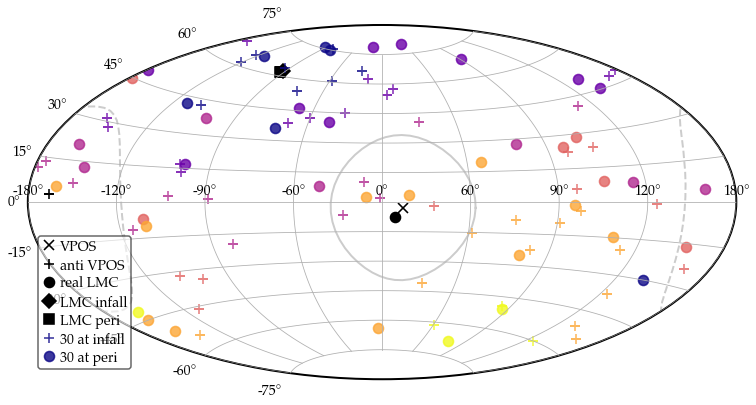

In [206]:
#smooth circles to define VPOS centered at (169.3, -2.8) with an opening angle of 36.87 deg
phi = np.linspace(0, 2.*np.pi, 50)  
r = np.radians(36.87)
x = np.radians((169.3-180)*-1) + r*np.cos(phi)
y = np.radians(-2.8) + r*np.sin(phi)

#define the antivpos (each side of it)
xx = np.radians((169.3)*-1) + r*np.cos(phi)
newx = [np.radians((np.degrees(x)+360.)) for x in xx]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, projection="aitoff")

# plot VPOS and anti-VPOS
ax1.plot(np.radians((169.3-180.)*-1), np.radians(-2.8), 'x',color='k', ms=10, label='VPOS')
ax1.plot(x, y, '-', color="k",alpha=0.2)
ax1.plot(xx, y, '-', color='k',ls='--', alpha=0.2)
ax1.plot(newx, y, 'k', ls='--',alpha=0.2)
ax1.plot(np.radians(169.3*-1), np.radians(2.8), '+',color='k', ms=10, label='anti VPOS')
ax1.grid(True)

#change x-axis labels to go from -180 t0 180
xs_lab = [np.radians(r) for r in [-180,-135, -90, -45, 0, 45, 90, 135, 180]]
ax1.set_xticks(xs_lab)


#add LMC to Aitoff
lmcr = [-1.1, -41.1, -27.9]
lmcv = [-57., -226., 221.]
l,b = orbpole(lmcr,lmcv)
newl = (l-180)*-1
plt.plot(np.radians(newl), np.radians(b), 'o', color='k', ms=10, label='real LMC')


# add m12b's LMC analog at infall
m12bl,m12bb = orb_pole_aitoff_single(lmc_pole_at_infall)
m12bl = (m12bl-180)*-1
plt.plot(np.radians(m12bl), np.radians(m12bb), 'D', color='k', label='LMC infall')

# add m12b's LMC analog at peri
m12bl,m12bb = orb_pole_aitoff_single(lmc_pole_at_peri)
m12bl = (m12bl-180)*-1
plt.plot(np.radians(m12bl), np.radians(m12bb), 's', color='k', label='LMC peri')

colors_ = color_cycle(angle_bins[1:].size)

#add m12b subhalos at infall
for i, (angle, angle_mask, c) in enumerate(zip(angle_bins[1:], angle_mask_at_infall, colors_)):
    orb_poles_ = pole_snap_arr[snap_at_lmc_infall,angle_mask,:]
    # remove nan's (lost subhalos) bc orb pole func can't deal w/ them
    orb_poles_ = np.compress(~np.isnan(orb_poles_[:,0]), orb_poles_[:,:], axis=0)
    orb_disp_vs_time.append(orbital_pole_dispersion(orb_poles_))
    m12bl,m12bb = orb_pole_aitoff(orb_poles_)
    m12bl = (m12bl-180)*-1
    if i == 0:
        plt.plot(np.radians(m12bl), np.radians(m12bb), '+', label=str(angle)+' at infall', alpha=0.8, color=c)
    else:
        plt.plot(np.radians(m12bl), np.radians(m12bb), '+', alpha=0.8, color=c)

    orb_poles_ = pole_snap_arr[snap_at_lmc_peri,angle_mask,:]
    # remove nan's (lost subhalos) bc orb pole func can't deal w/ them
    orb_poles_ = np.compress(~np.isnan(orb_poles_[:,0]), orb_poles_[:,:], axis=0)
    orb_disp_vs_time.append(orbital_pole_dispersion(orb_poles_))
    m12bl,m12bb = orb_pole_aitoff(orb_poles_)
    m12bl = (m12bl-180)*-1
    if i == 0:
        plt.plot(np.radians(m12bl), np.radians(m12bb), 'o', label=str(angle)+' at peri', alpha=0.8, color=c)
    else:
        plt.plot(np.radians(m12bl), np.radians(m12bb), 'o', alpha=0.8, color=c)

plt.legend(loc=3)
plt.show()

### Do the same as above, but wrt halo center

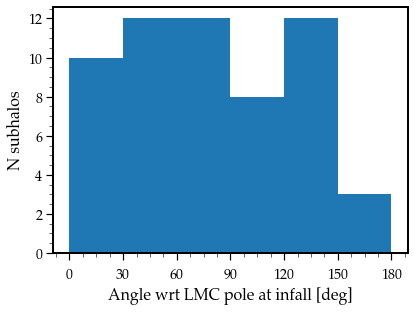

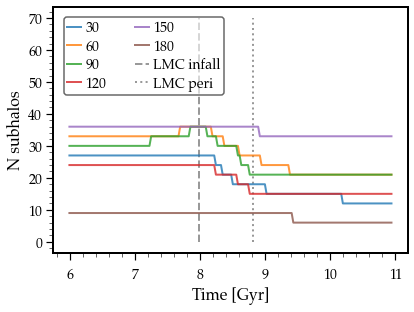

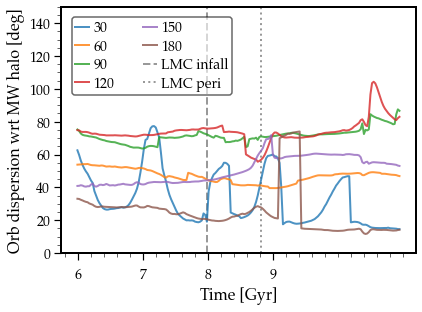

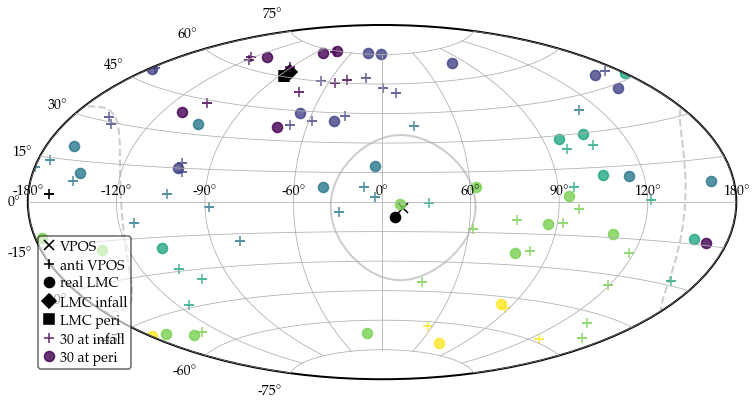

In [208]:
pole_snap_arr_halo = np.full_like(m12b_subhalos['position'], np.nan)

for snap in near_infall_snapshots:
    # first mask out nan-entry subhalos at each snapshot
    # these are subhalos that were within 50-500 kpc of the host halo at some point during z=0-1
    # but do not exist in the tree at this snapshot
    subhalo_positions = np.compress(~np.isnan(m12b_subhalos['position'][snap,:,0]), m12b_subhalos['position'][snap,:,:], axis=0)
    subhalo_velocities = np.compress(~np.isnan(m12b_subhalos['velocity'][snap,:,0]), m12b_subhalos['velocity'][snap,:,:], axis=0)
    assert subhalo_positions.shape == subhalo_velocities.shape

    # convert to a disc-centered coordinate system
    subhalo_halo_position = ut.coordinate.get_distances(subhalo_positions, halo_pos[snap,:])
    subhalo_halo_velocity = ut.coordinate.get_distances(subhalo_velocities, halo_vel[snap,:])

    poles = get_poles(subhalo_halo_position, subhalo_halo_velocity)

    # broadcast only to where there were extant subhalos in the tree
    tracked_sub_indices = np.asarray(~np.isnan(m12b_subhalos['position'][snap,:,0])).nonzero()
    pole_snap_arr_halo[snap,tracked_sub_indices,:] = poles

# get angles between subhalo poles and lmc pole at lmc infall
lmc_halo_orb_poles = pole_snap_arr_halo[:,lmc_subhalo_index,:]
lmc_halo_pole_at_infall = lmc_halo_orb_poles[snap_at_lmc_infall]
lmc_halo_pole_at_peri = lmc_halo_orb_poles[snap_at_lmc_peri]
halo_pole_angle_wrt_lmc = get_angles_btwn_poles(lmc_halo_pole_at_infall, pole_snap_arr_halo[snap_at_lmc_infall,:,:])

plt.hist(np.abs(halo_pole_angle_wrt_lmc), bins=angle_bins)
plt.xticks(angle_bins)
plt.xlabel('Angle wrt LMC pole at infall [deg]', fontsize=16)
plt.ylabel('N subhalos', fontsize=16)
plt.show()

################################################################################

# get orbital dispersion for subhalos binned by pole alignment
halo_angle_mask_at_infall = np.zeros((angle_bins.size-1, pole_snap_arr_halo[snap_at_lmc_infall,:,:].shape[0]), dtype=bool)
for i,angle in enumerate(angle_bins[:-1]):
    angle_ = angle_bins[i+1]
    halo_angle_mask_at_infall[i] = (np.abs(halo_pole_angle_wrt_lmc) > angle) & (np.abs(halo_pole_angle_wrt_lmc) <= angle_)


# plot number of subhalos in each bin over time
for angle, angle_mask in zip(angle_bins[1:], halo_angle_mask_at_infall):
    n_vs_time = []
    for snap in near_infall_snapshots:
        orb_poles_ = pole_snap_arr_halo[snap,angle_mask,:]
        n_vs_time.append(np.sum(~np.isnan(orb_poles_)))
    plt.plot(near_infall_times, n_vs_time, label=str(angle), alpha=0.8)
plt.vlines(t_infall, 0, 70, alpha=0.4, linestyles='--', color='k', label='LMC infall')
plt.vlines(t_peri, 0, 70, alpha=0.4, linestyles=':', color='k', label='LMC peri')
plt.legend(ncol=2, loc=2)
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('N subhalos', fontsize=16)
plt.xticks(np.arange(6,12,1))
plt.show()

################################################################################

# follow orbital dispersion of each bin separately
for angle, angle_mask in zip(angle_bins[1:], halo_angle_mask_at_infall):
    orb_disp_vs_time = []
    for snap in near_infall_snapshots:
        orb_poles_ = pole_snap_arr_halo[snap,angle_mask,:]
        # remove nan's (lost subhalos) bc orb pole func can't deal w/ them
        orb_poles_ = np.compress(~np.isnan(orb_poles_[:,0]), orb_poles_[:,:], axis=0)
        orb_disp_vs_time.append(orbital_pole_dispersion(orb_poles_))
    plt.plot(near_infall_times, orb_disp_vs_time, label=str(angle), alpha=0.8)
plt.vlines(t_infall, 0, 160, alpha=0.4, linestyles='--', color='k', label='LMC infall')
plt.vlines(t_peri, 0, 160, alpha=0.4, linestyles=':', color='k', label='LMC peri')
plt.legend(ncol=2, loc=2)
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Orb dispersion wrt MW halo [deg]', fontsize=16)
#plt.xlim((7.8,14))
plt.ylim((0,150))
plt.xticks(np.arange(6,10,1))
plt.show()


################################################################################

#smooth circles to define VPOS centered at (169.3, -2.8) with an opening angle of 36.87 deg
phi = np.linspace(0, 2.*np.pi, 50)  
r = np.radians(36.87)
x = np.radians((169.3-180)*-1) + r*np.cos(phi)
y = np.radians(-2.8) + r*np.sin(phi)

#define the antivpos (each side of it)
xx = np.radians((169.3)*-1) + r*np.cos(phi)
newx = [np.radians((np.degrees(x)+360.)) for x in xx]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, projection="aitoff")

# plot VPOS and anti-VPOS
ax1.plot(np.radians((169.3-180.)*-1), np.radians(-2.8), 'x',color='k', ms=10, label='VPOS')
ax1.plot(x, y, '-', color="k",alpha=0.2)
ax1.plot(xx, y, '-', color='k',ls='--', alpha=0.2)
ax1.plot(newx, y, 'k', ls='--',alpha=0.2)
ax1.plot(np.radians(169.3*-1), np.radians(2.8), '+',color='k', ms=10, label='anti VPOS')
ax1.grid(True)

#change x-axis labels to go from -180 t0 180
xs_lab = [np.radians(r) for r in [-180,-135, -90, -45, 0, 45, 90, 135, 180]]
ax1.set_xticks(xs_lab)


#add LMC to Aitoff
lmcr = [-1.1, -41.1, -27.9]
lmcv = [-57., -226., 221.]

l,b = orbpole(lmcr,lmcv)
newl = (l-180)*-1
plt.plot(np.radians(newl), np.radians(b), 'o', color='k', ms=10, label='real LMC')


# add m12b's LMC analog at infall
m12bl,m12bb = orb_pole_aitoff_single(lmc_halo_pole_at_infall)
m12bl = (m12bl-180)*-1
plt.plot(np.radians(m12bl), np.radians(m12bb), 'D', color='k', label='LMC infall')

# add m12b's LMC analog at peri
m12bl,m12bb = orb_pole_aitoff_single(lmc_halo_pole_at_peri)
m12bl = (m12bl-180)*-1
plt.plot(np.radians(m12bl), np.radians(m12bb), 's', color='k', label='LMC peri')

colors_ = color_cycle(angle_bins[1:].size, cmap_name='viridis')

#add m12b subhalos at infall
for i, (angle, angle_mask, c) in enumerate(zip(angle_bins[1:], angle_mask_at_infall, colors_)):
    orb_poles_ = pole_snap_arr_halo[snap_at_lmc_infall,angle_mask,:]
    # remove nan's (lost subhalos) bc orb pole func can't deal w/ them
    orb_poles_ = np.compress(~np.isnan(orb_poles_[:,0]), orb_poles_[:,:], axis=0)
    orb_disp_vs_time.append(orbital_pole_dispersion(orb_poles_))
    m12bl,m12bb = orb_pole_aitoff(orb_poles_)
    m12bl = (m12bl-180)*-1
    if i == 0:
        plt.plot(np.radians(m12bl), np.radians(m12bb), '+', label=str(angle)+' at infall', alpha=0.8, color=c)
    else:
        plt.plot(np.radians(m12bl), np.radians(m12bb), '+', alpha=0.8, color=c)

    orb_poles_ = pole_snap_arr_halo[snap_at_lmc_peri,angle_mask,:]
    # remove nan's (lost subhalos) bc orb pole func can't deal w/ them
    orb_poles_ = np.compress(~np.isnan(orb_poles_[:,0]), orb_poles_[:,:], axis=0)
    orb_disp_vs_time.append(orbital_pole_dispersion(orb_poles_))
    m12bl,m12bb = orb_pole_aitoff(orb_poles_)
    m12bl = (m12bl-180)*-1
    if i == 0:
        plt.plot(np.radians(m12bl), np.radians(m12bb), 'o', label=str(angle)+' at peri', alpha=0.8, color=c)
    else:
        plt.plot(np.radians(m12bl), np.radians(m12bb), 'o', alpha=0.8, color=c)

plt.legend(loc=3)
plt.show()